# BARGAV JAGATHA

#### BU ID : U80005052

## MANUAL TRADING

- Made the manual predictions for three days : Sept 23 to Sept 25, on Austin High temperature.
- Money went down, because placed "Yes" bets from the Google weather, and from other internet sources.

- ##### Insights : "No" bets are safer, since we can place them when we are so sure that temperatute no going to be in that given range.

##### Price Movements from Kalshi

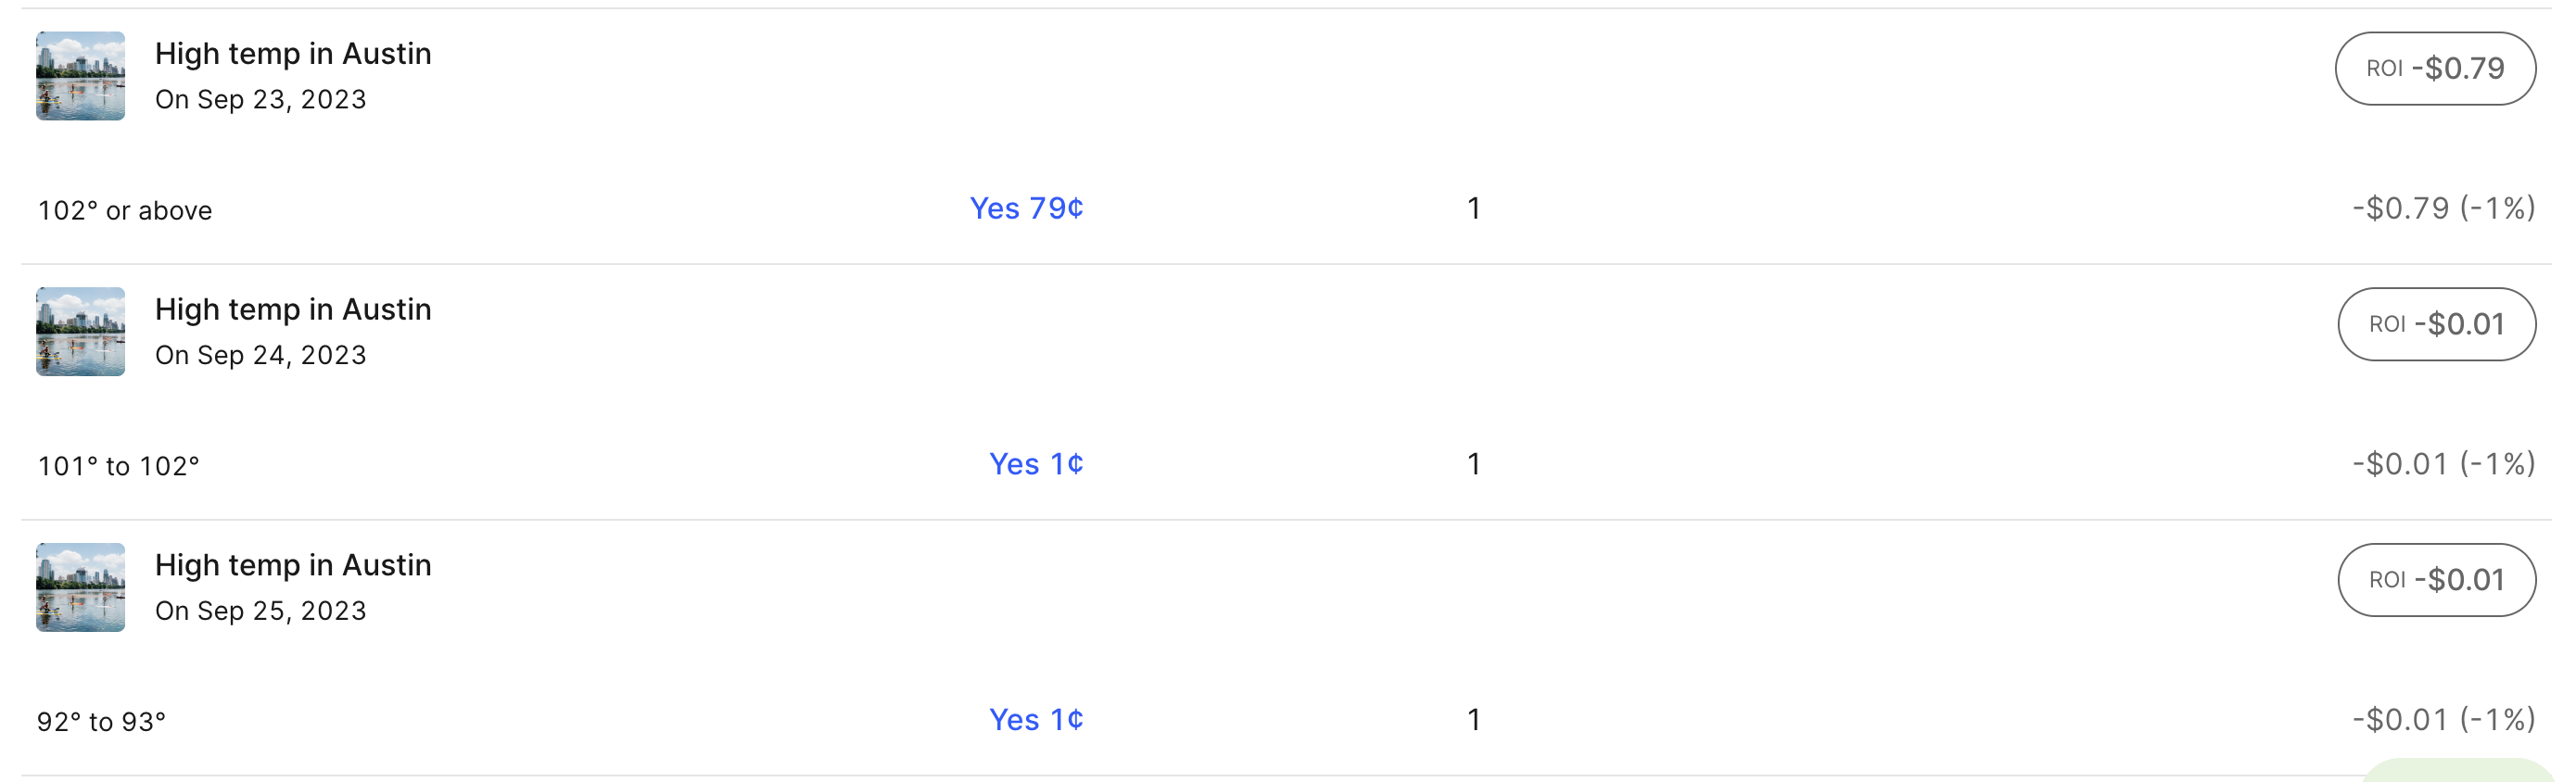

In [40]:
from IPython.display import Image

Image("srcshots/manual_pred_1.png")

## DATA COLLECTION

- ##### Moved to 'New York', because the data sources available for it are more.

- Collected the data from five sources, that includes other weather related features like wind speed, humidity, percipitation etc. in addition to temperature

#### 1. NOAA : National Oceanic and Atmospheric Administration

In [19]:
import requests
import pandas as pd

In [11]:
url = "https://www.ncei.noaa.gov/cdo-web/api/v2/datasets"

api_token = 'api_key'

headers={'token': api_token}

response = requests.get(url, headers = headers)

for data in response.json()['results'][:3]:
    print(data['name'])

Daily Summaries 	
Global Summary of the Month 	
Global Summary of the Year 	


- Drawback : Hourly data is not available in NOAA


#### 2. NWS : National Weather Service

- Drawback : The API offers only previous two months data is available


#### 3. Meteostat Python Library

- ##### 'KNYC' is station id for Central Park, New York

In [13]:
from datetime import datetime
from meteostat import Hourly

start = datetime(2000, 1, 1)
end = datetime(2023, 10, 6, 23, 59)

# Get hourly data
data = Hourly('KNYC0', start, end)
data = data.fetch()

data.head(5)

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2000-01-01 05:00:00,2.8,1.6,92.0,NaN,NaN,280.0,9.4,NaN,1022.0,NaN,NaN
2000-01-01 06:00:00,2.8,1.6,92.0,0.0,NaN,280.0,7.6,NaN,1022.0,NaN,NaN
2000-01-01 07:00:00,2.8,1.6,92.0,0.0,NaN,260.0,11.2,NaN,1022.4,NaN,NaN
2000-01-01 08:00:00,2.8,1.6,92.0,0.0,NaN,260.0,13.0,NaN,1022.7,NaN,NaN
2000-01-01 09:00:00,2.2,2.2,100.0,0.0,NaN,270.0,13.0,NaN,1023.2,NaN,NaN


- Drawback : The data is inconsistent with the real weather data


#### 4. Kaggle Datasets

Kaggle has plenty of datasets for New York historical weather data, both hourly and daily. 
But they don't have recent weather data for obvious reasons, which is so important for training the model.

Example : https://www.kaggle.com/datasets/tavoglc/new-york-weather-1869-2023

#### 5. Visual Crossing API

In [29]:

import urllib.request

import datetime
datetime.date.today()

api_key = "api_key"
start_date = '2023-10-05'
end_date = '2023-10-10'

url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Central%20Park%20New%20York/{start_date}/{end_date}?unitGroup=us&maxDistance=1000&include=hours&key={api_key}&elevationDifference=1&contentType=csv'
destination = '../Data/infer_temp.csv'

urllib.request.urlretrieve(url, destination)

df = pd.read_csv(destination)

df[['datetime', 'temp', 'humidity', 'dew', 'precip', 'windspeed','winddir', 'snow', 'snowdepth' ]].head()

,datetime,temp,humidity,dew,precip,windspeed,winddir,snow,snowdepth
0,2023-10-05T00:00:00,67.0,75.23,58.9,0.0,3.4,170,0,0
1,2023-10-05T01:00:00,65.0,83.74,60.0,0.0,2.2,180,0,0
2,2023-10-05T02:00:00,63.9,83.67,58.9,0.0,2.2,170,0,0
3,2023-10-05T03:00:00,63.1,83.61,58.0,0.0,2.2,170,0,0
4,2023-10-05T04:00:00,63.1,77.85,56.0,0.0,2.2,170,0,0


- Drawback : Limit on retreiving data. 1000 Data points per day


## MODEL TRAINING

Considering all the options and their limitations, Visual Crossing seem good idea

After calling the API for multiple days, I am able to retrieve 3 months hourly data : July - September 2023

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm

df = pd.read_csv('3months_vc.csv')

df = df[['datetime', 'temp', 'precip', 'humidity', 'windspeed', 'sealevelpressure', 'winddir', ]]
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date

# Feature Engineering : Creating historical Features - day level

day_df_max = df.groupby('date')[['temp', 'precip', 'humidity', 'windspeed']].agg('max')
day_df_min = df.groupby('date')[['temp', 'precip', 'humidity', 'windspeed']].agg('min')

day_df_max['max_precip_prev1d'] = day_df_max['precip'].rolling(1, closed = 'left').max()
day_df_max['max_precip_prev3d'] = day_df_max['precip'].rolling(3, closed = 'left').max()

day_df_max['max_temp_prev1d'] = day_df_max['temp'].rolling(1, closed = 'left').max()
day_df_max['max_temp_prev3d'] = day_df_max['temp'].rolling(3, closed = 'left').max()

day_df_max['min_precip_prev1d'] = day_df_min['precip'].rolling(1, closed = 'left').min()
day_df_max['min_precip_prev3d'] = day_df_min['precip'].rolling(3, closed = 'left').min()

day_df_max['min_temp_prev1d'] = day_df_min['temp'].rolling(1, closed = 'left').min()
day_df_max['min_temp_prev3d'] = day_df_min['temp'].rolling(3, closed = 'left').min()

day_df_max.rename(columns = {'temp':'temp_label'}, inplace = True)
day_df_max.drop(['precip', 'humidity', 'windspeed'], axis = 1, inplace = True)



# Day and month features

df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

df = pd.merge(df, day_df_max, on = 'date', how = 'left')

# Adding lag features - temp, hour level

for i in range(1,24):
    df[f'temp_lag_{i}'] = df['temp'].shift(i)

# Since beginning rows for creating lag features, they may contain so many NaNs

df = df.iloc[72:]
df.fillna(-1, inplace = True)

df.drop(['datetime'], axis = 1, inplace = True)

# Creating train test split --> so that test set being the last 10 days and train being the days before that

train_df = df[df['date'] <= pd.to_datetime('2023-09-20').date()]
test_df = df[df['date'] > pd.to_datetime('2023-09-20').date()]

X_train, y_train = train_df.drop(['temp_label', 'date'], axis = 1).values, train_df['temp'].values
X_test, y_test = test_df.drop(['temp_label', 'date'], axis = 1).values, test_df['temp'].values

# XGB model, (It doesn't require scaling features, since it is a tree based ensemble model)

xgb_reg = XGBRegressor()

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

print(f'MAE on 10 days test set : {mean_absolute_error(y_test, y_pred):.3f}')


MAE on 10 days test set : 0.359


#### Predicted and Ground Truth values over time for historic data

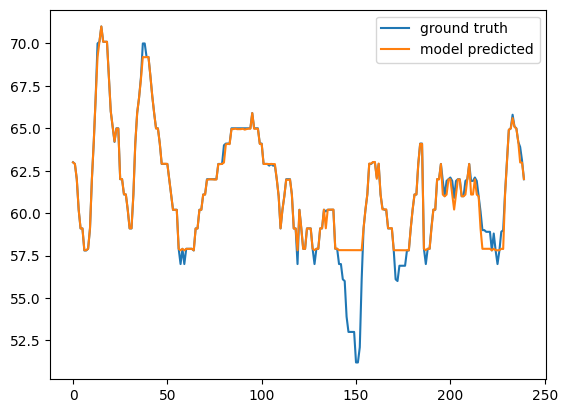

In [34]:
plt.plot(y_test, label = 'ground truth')
plt.plot(y_pred, label = 'model predicted')
plt.legend()
plt.show()

##### Using the predictions from above model, able to get around 600$ profit from minimal investment

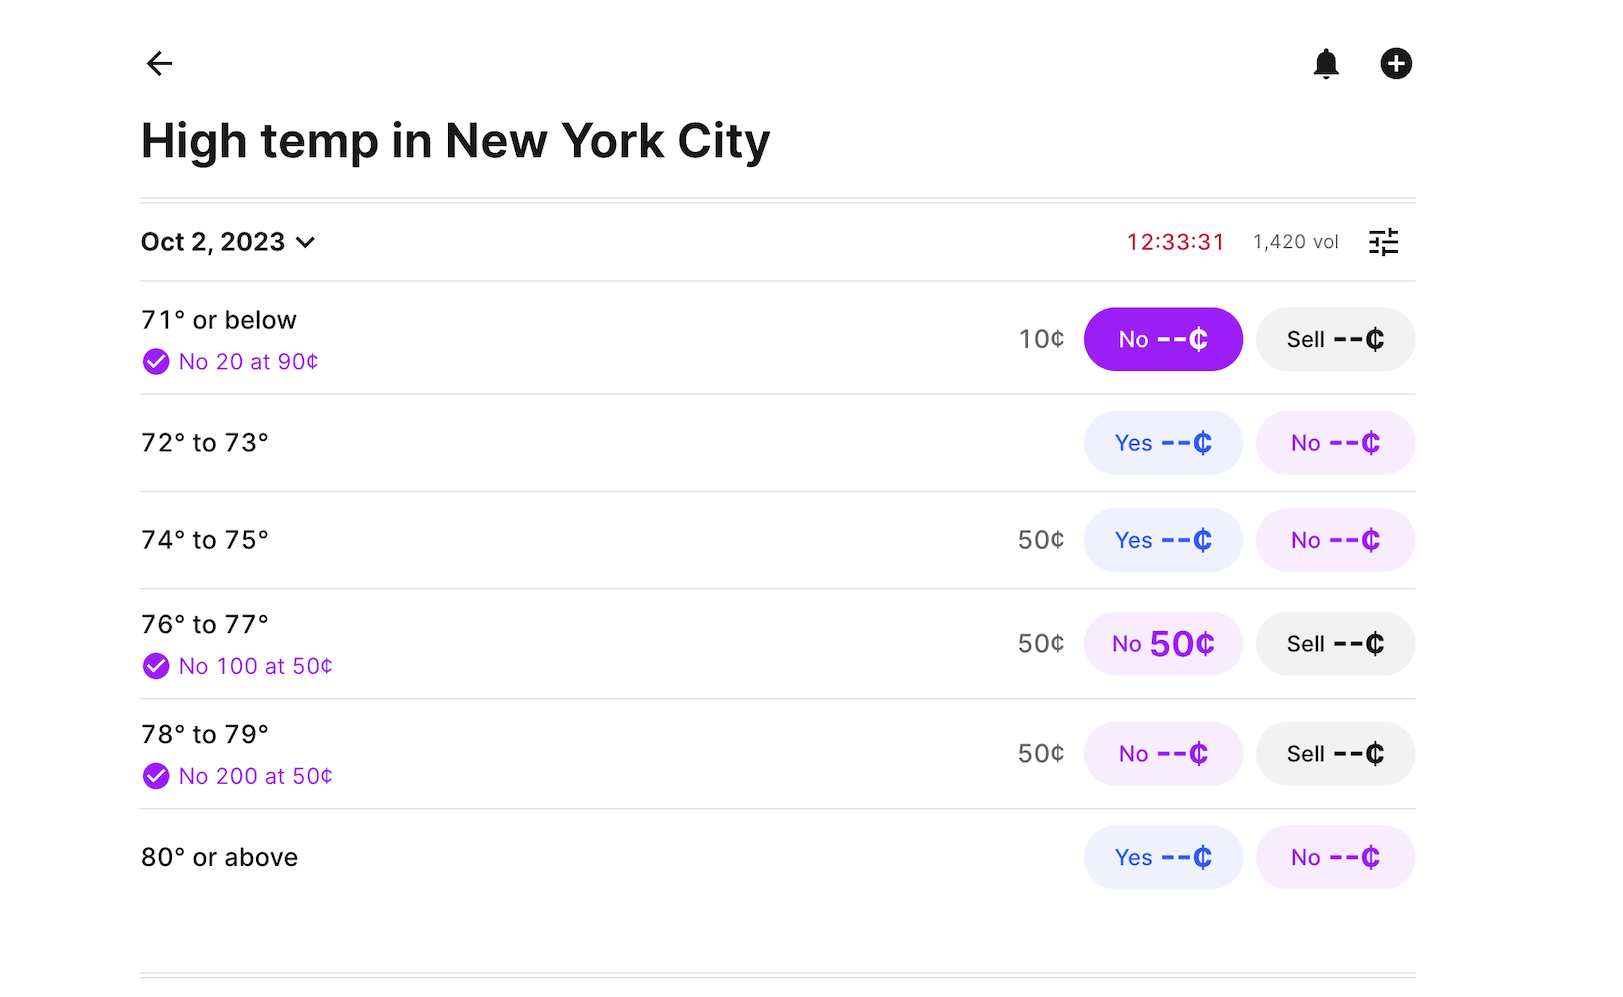

In [38]:
from IPython.display import Image

Image("srcshots/oct_2_invest.png")

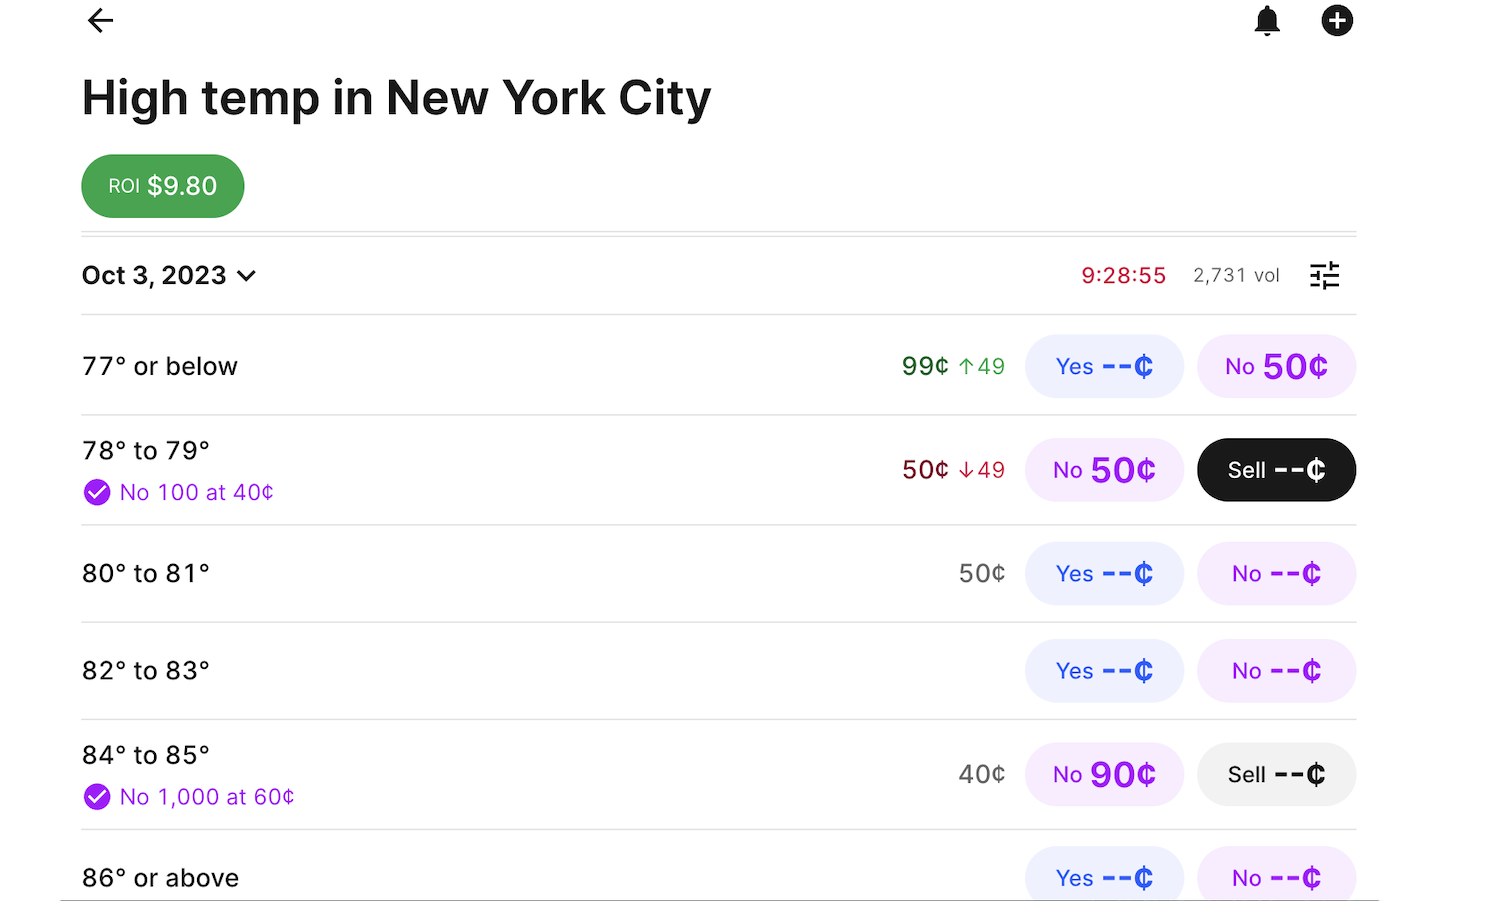

In [39]:
from IPython.display import Image

Image("srcshots/oct_3_invest.png")

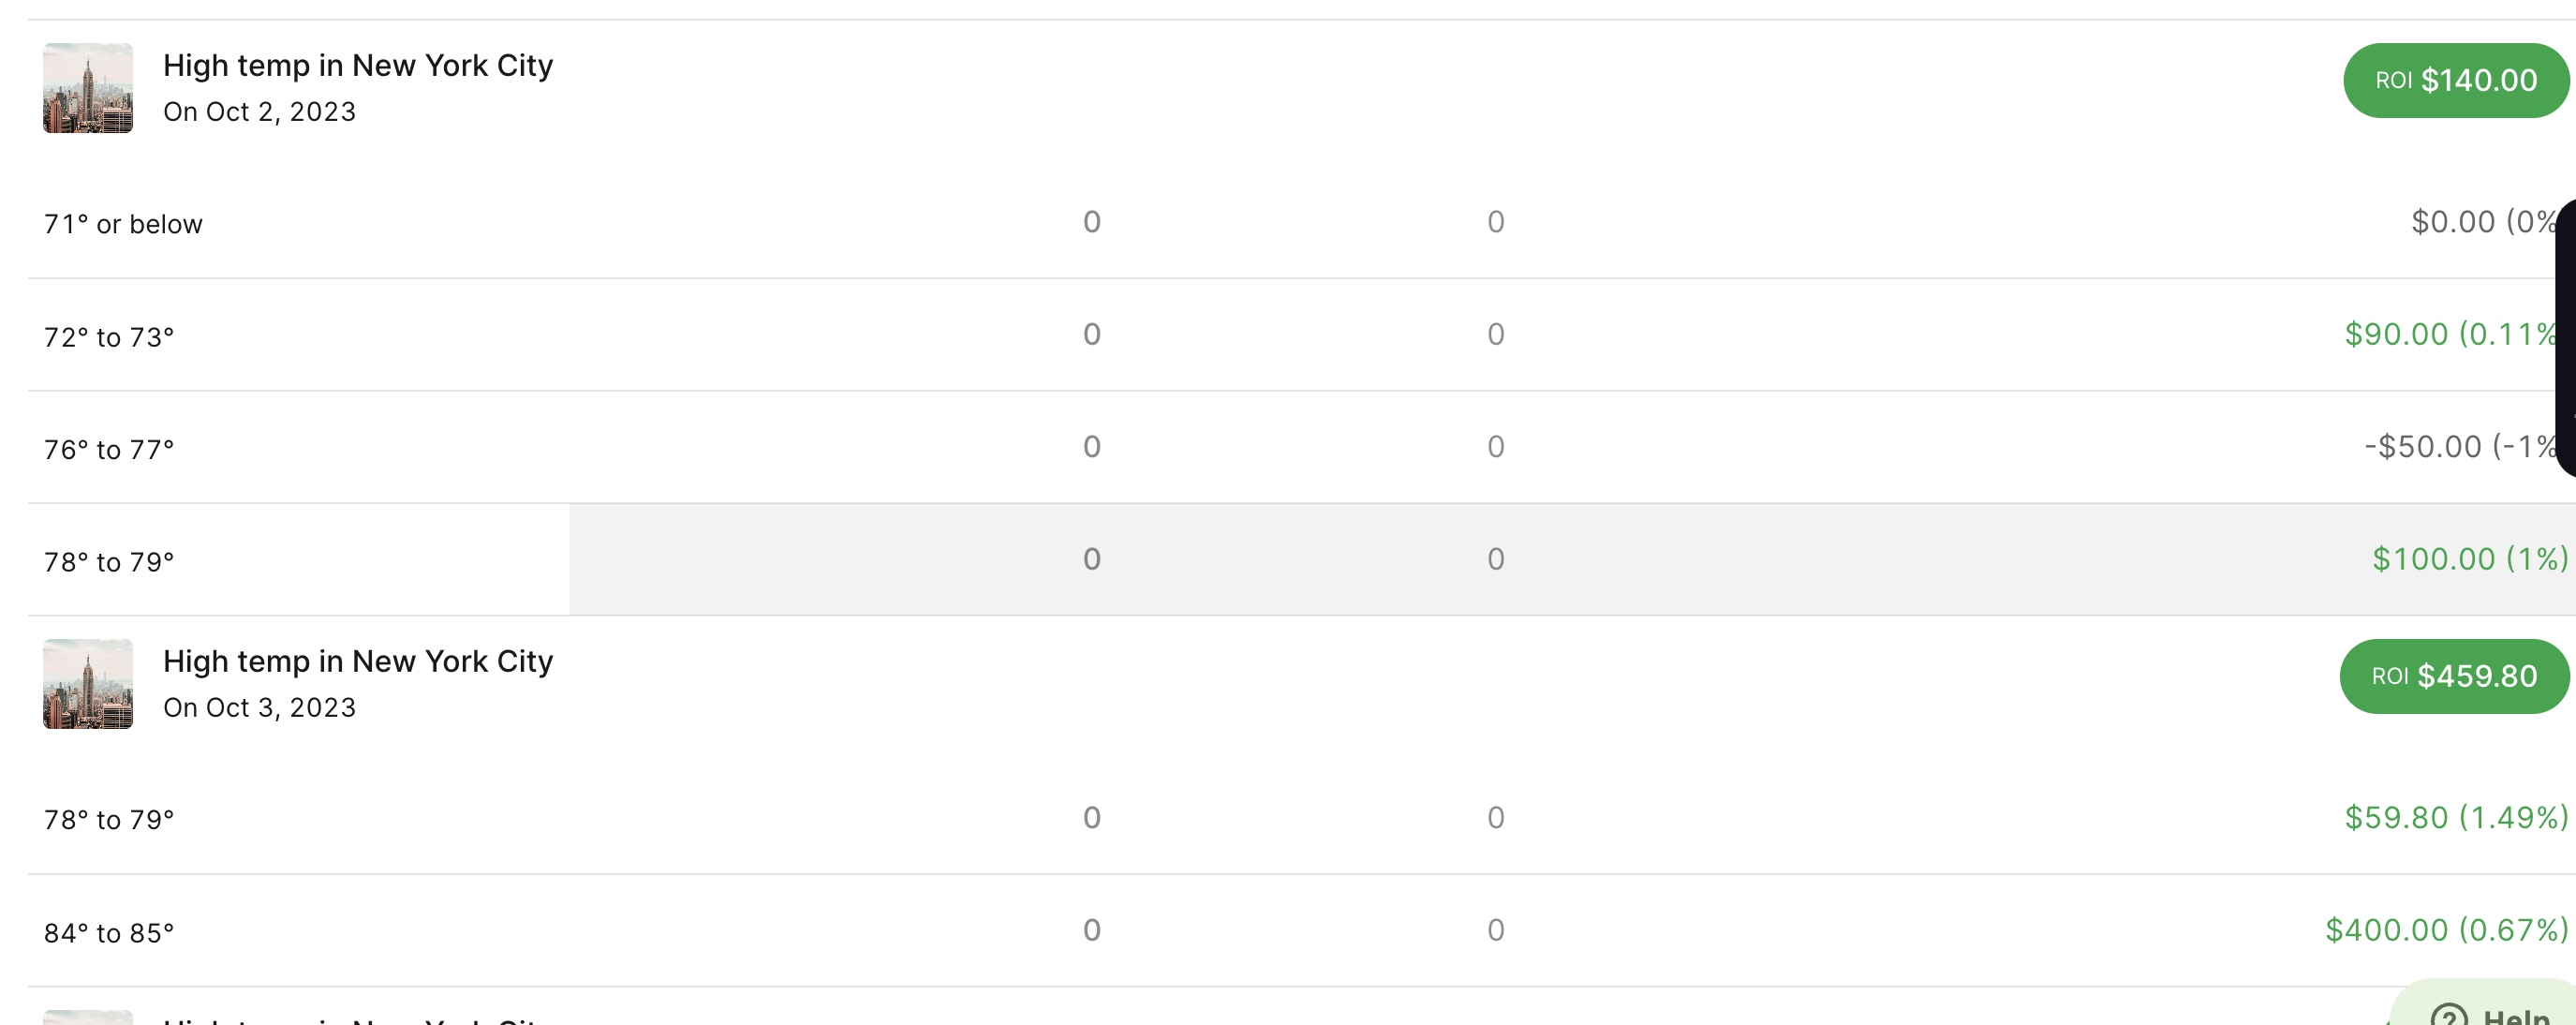

In [35]:
from IPython.display import Image

Image("srcshots/oct_2_3_profits.png")

## AUTOMATIC TRADING

Kalshi offers free API which lets users to place order and check the market status or order status

Automatic trading pipelines involves :

- Loading the trained model
- Getting the live data needed for inference and preprocessing it for the same.
- Using Kalshi API, filter the markets for 'HIGHNY' and the today date.
- Predict the maximum temperatue of the day through the model, and place the "no" order on the farthest range ticker from predicted value.

In [3]:

import kalshi_python

from KalshiClientsBaseV2 import ExchangeClient
import time
import json
import uuid


import urllib.request
import pandas as pd
import numpy as np
import pickle

import datetime



In [4]:
# Loading the credentials and create the ExchangeClient

api_key = "visual_crossing_api_here"
start_date = str(datetime.date.today() - datetime.timedelta(days = 5))
end_date = str(datetime.date.today())

demo_email = "" 
demo_password = "" 

demo_api_base = "https://demo-api.kalshi.co/trade-api/v2"


exchange_client = ExchangeClient(exchange_api_base = demo_api_base, email = demo_email, password = demo_password)

print(exchange_client.get_exchange_status())

{'exchange_active': True, 'trading_active': True}


In [7]:
ticker_name = "HIGHNY-23OCT11"

In [9]:
# Load the model and data

url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Central%20Park%20New%20York/{start_date}/{end_date}?unitGroup=us&maxDistance=1000&include=hours&key={api_key}&elevationDifference=1&contentType=csv'
destination = '../Data/infer_temp.csv'

urllib.request.urlretrieve(url, destination)

df = pd.read_csv(destination)

file = open("../models/xgb_reg_final.pkl",'rb')
model = pickle.load(file)
file.close()


In [12]:
# For a given ticker, get all the markets

def get_markets_for_ticker(event_ticker):

    cursor = None

    # You can discover markets through the get_markets endpoint...    
    # and use query parameters to filter your search!


    market_params = {'limit':200,
                        'cursor':cursor, # passing in the cursor from the previous get_markets call
                        'event_ticker': event_ticker,
                        'series_ticker':None,
                        'max_close_ts':None, # pass in unix_ts
                        'min_close_ts':None, # pass in unix_ts
                        'status':None,
                        'tickers':None}
    
    markets_response = exchange_client.get_markets(**market_params)
    cursor = markets_response['cursor']

    return markets_response['markets']
    

## Making model predict the data

def give_max_pred(model, df):

    df = df.copy()

    df = df[['datetime', 'temp', 'precip', 'humidity', 'windspeed', 'sealevelpressure', 'winddir']]

    df['datetime'] = pd.to_datetime(df['datetime'])

    df['date'] = df['datetime'].dt.date

    day_df_max = df.groupby('date')[['temp', 'precip', 'humidity', 'windspeed']].agg('max')
    day_df_min = df.groupby('date')[['temp', 'precip', 'humidity', 'windspeed']].agg('min')

    day_df_max['max_precip_prev1d'] = day_df_max['precip'].rolling(1).max()
    day_df_max['max_precip_prev3d'] = day_df_max['precip'].rolling(3).max()
    
    day_df_max['max_temp_prev1d'] = day_df_max['temp'].rolling(1).max()
    day_df_max['max_temp_prev3d'] = day_df_max['temp'].rolling(3).max()

    day_df_max['min_precip_prev1d'] = day_df_min['precip'].rolling(1).min()
    day_df_max['min_precip_prev3d'] = day_df_min['precip'].rolling(3).min()
    
    day_df_max['min_temp_prev1d'] = day_df_min['temp'].rolling(1).min()
    day_df_max['min_temp_prev3d'] = day_df_min['temp'].rolling(3).min()

    day_df_max.drop(['temp', 'precip', 'humidity', 'windspeed'], axis = 1, inplace = True)


    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['hour'] = df['datetime'].dt.hour

    df = pd.merge(df, day_df_max, on = 'date', how = 'left')

    for i in range(1,24):
        df[f'temp_lag_{i}'] = df['temp'].shift(i)

    df = df.iloc[72:]

    df.fillna(-1, inplace = True)

    curr_hr = datetime.datetime.now().hour
    curr_date = str(datetime.date.today())


    df = df[~((df['date'] == pd.to_datetime(curr_date).date()) & (df['hour'] > curr_hr))]

    df.drop(['datetime'], axis = 1, inplace = True)

    X_test = df.drop(['date'], axis = 1)

    y_pred = model.predict(X_test)

    return y_pred[0]
    

# get the temperature ranges for all the markets

def get_temps_steps(markets):

    temp_vals = []
    ticker_list = []

    for mar in markets:
        
            l_tokens = mar['subtitle'].split()
        
            if "or" in l_tokens:
        
                num = int(l_tokens[0][:-1])
        
                temp_vals.append(num)
    
                ticker_list.append(mar['ticker'])
        
            else:
                
                num1 = int(l_tokens[0][:-1])
                num2 = int(l_tokens[-1][:-1])
        
                temp_vals.append((num1 + num2)/2)
    
                ticker_list.append(mar['ticker'])

    return temp_vals, ticker_list


# Function to place order

def place_order(ticker, side, count = 10, type = 'market'):

    order_params = {'ticker':ticker,
                    'client_order_id':str(uuid.uuid4()),
                    'type':type,
                    'action':'buy',
                    'side':side,
                    'count':count,
                    'expiration_ts':None,
                    'sell_position_floor':None,
                    'buy_max_cost':None}

    exchange_client.create_order(**order_params)


In [18]:
# Prediciting from the model

pred_val = give_max_pred(model, df)
pred_val

print(f"Prediced max temp for today is {pred_val:.3f}", '\n')

markets = get_markets_for_ticker(ticker_name)

print(f'There are {len(markets)} markets for the given ticker', '\n')

temp_vals, ticker_list = get_temps_steps(markets)

print(f'Temperature ranges : {temp_vals}', '\n')

safe_ind = np.argmax(abs(np.array(temp_vals) - pred_val))

print(f'Farthest range : {temp_vals[safe_ind]} and ticker : {ticker_list[safe_ind]}', '\n')


Prediced max temp for today is 57.814 

There are 6 markets for the given ticker 

Temperature ranges : [71, 62, 69.5, 67.5, 65.5, 63.5] 

Farthest range : 71 and ticker : HIGHNY-23OCT11-T70 



In [19]:
# Placing order

print(f'Placing the order\n')

place_order(ticker_list[safe_ind], "no", 400)


Placing the order

{'ticker': 'HIGHNY-23OCT11-T70', 'client_order_id': '108fd713-2f54-4b38-b3fb-14fcd0fea81d', 'side': 'no', 'action': 'buy', 'count': 400, 'type': 'market'}


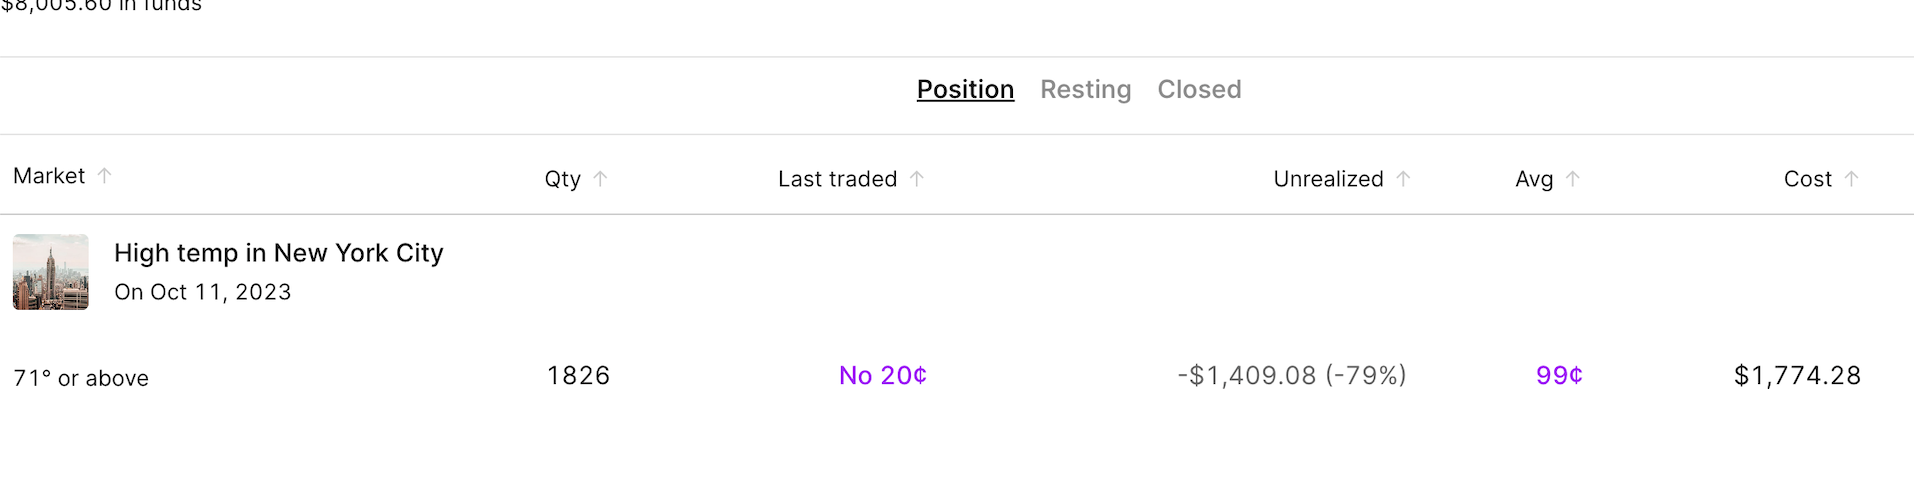

In [20]:
from IPython.display import Image

Image("srcshots/oct_11_invest.png")

#### Returns from Automatic Tradings.

##### Huge profit from the above trade

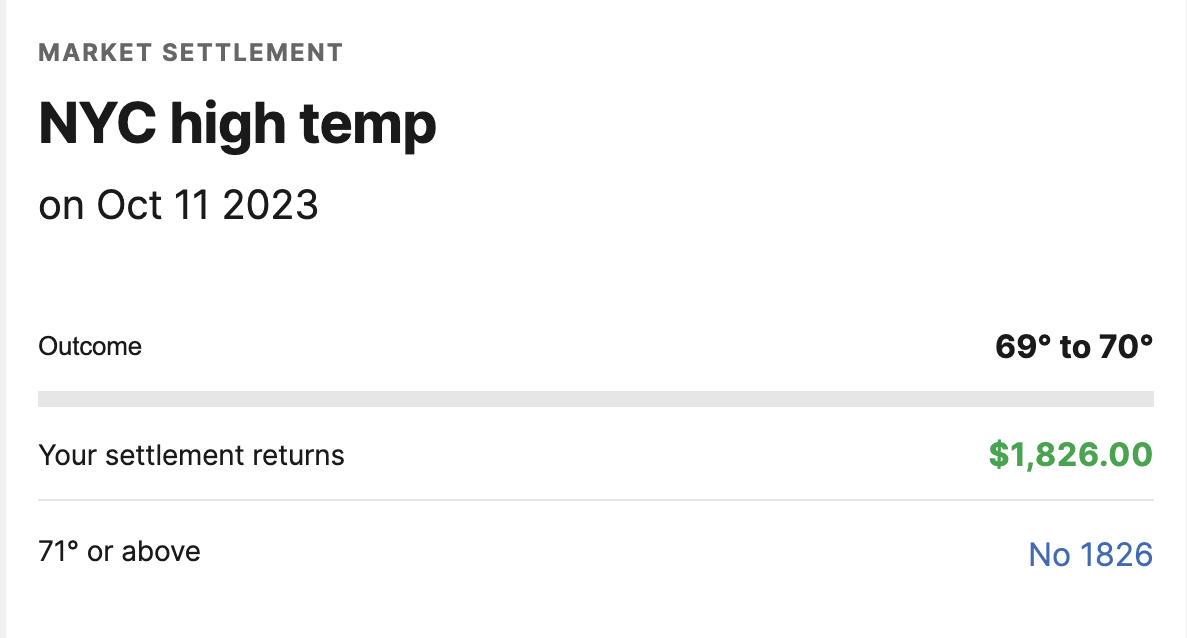

In [1]:
from IPython.display import Image

Image("srcshots/oct_11_profit.png")


##### Returns from other trades

Used a different approach to placing orders for below, in a way that I bought all, but the count is proportional to the distance between the predicted value and the temp range of the respective market. But that didn't work as great as above.

Also, Kept the total count as minimal, that is why the price movement is so low

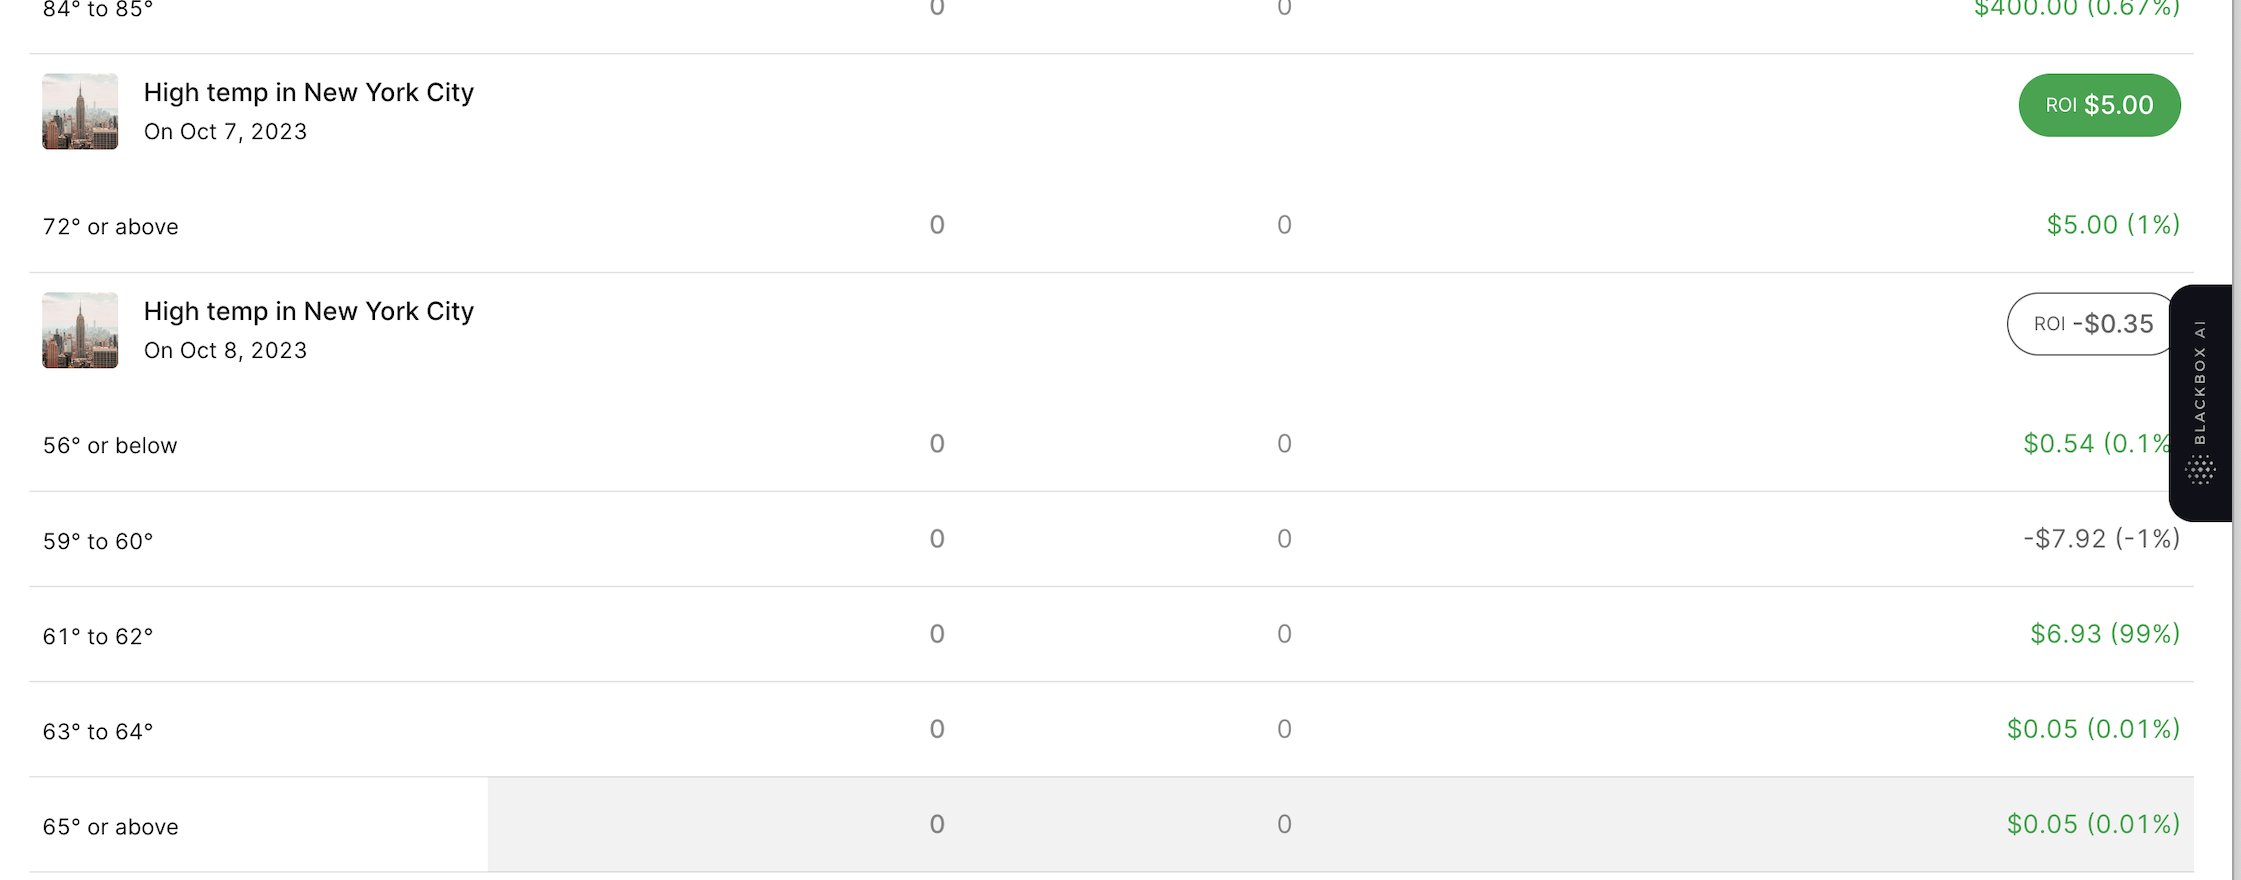

In [24]:
from IPython.display import Image

Image("srcshots/oct_7_8_returns.png")
